In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
from torch.optim import lr_scheduler                                                                                                                                                                                       
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import numpy as np
import time
import os

import logging
from zipfile import ZipFile
import gdown

## Define FCN16s model for deconvolution layers

torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1,
                             padding=0, output_padding=0, groups=1, bias=True, dilation=1)
                             
-  in_channels – the number of channels of the input signal
-  out_channels – the number of channels generated by convolution
-  kerner_size – size of convolution kernel
-  stride – Convolution step size, that is, the multiple of the input to be expanded.
-  padding – The height and width are increased by 2 * padding
-  output_padding – the height and width are increased by padding
-  groups – number of blocked connections from input channel to output channel
-  bias – if bias = True, add bias
-  dilation – spacing between elements of the convolution kernel

In [11]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super(FCN16s, self).__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        
        # After the feature extraction layer of vgg, you can get the feature map. 
        # The size of the feature map after 5 max_pools are respectively
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)
        x2 = output['x2']  # size=(N, 128, x.H/4,  x.W/4)
        x1 = output['x1']  # size=(N, 64, x.H/2,  x.W/2)
        
#===========FCN16s model ==========================
        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
#===========FCN16s model ==========================
        
#===========Please design a FCN8s model ===========
    

        
#===========Please design a FCN8s model ===========


        return score  # size=(N, n_class, x.H/1, x.W/1)

## Define VGG16 for convolution layers

In [12]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super(VGGNet, self).__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output

In [13]:
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [14]:
batch_size = 3
epochs     = 25  #500
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 50
gamma      = 0.5
model_use  = "subt_model" # "subt_model"
n_class = 5

## Download_dataset

In [15]:
dataset_url = "https://drive.google.com/u/1/uc?id=1ORB2iXh0Os-64WqIrE7rWJBsEvQsFTVs&export=download"
dataset_name = "data"
if not os.path.isdir(dataset_name):
    gdown.download(dataset_url, output=dataset_name + '.zip', quiet=False)
    zip1 = ZipFile(dataset_name + '.zip')
    zip1.extractall(dataset_name)
    zip1.close()
    os.remove("data.zip")

print("Finished downloading dataset.") 

Downloading...
From: https://drive.google.com/u/1/uc?id=1ORB2iXh0Os-64WqIrE7rWJBsEvQsFTVs&export=download
To: /home/sis_2020/ctsphub-workshop-2020/06-semantic-segmentation/data.zip
100%|██████████| 688k/688k [00:00<00:00, 35.1MB/s]

Finished downloading dataset.


## Define path, directory trainning environment

In [16]:
# get data
FullPath = os.getcwd()
data_dir  = os.path.join(FullPath + "/data/subt")
if not os.path.exists(data_dir):
    print("Data not found!")
    
# create dir for model
model_dir = os.path.join(FullPath + "/models", model_use)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
# create dir for score
score_dir = os.path.join(FullPath + "/scores", model_use)
if not os.path.exists(score_dir):
    os.makedirs(score_dir)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)

if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))
else:
#     nn.DataParallel(fcn_model)
    print("Use CPU to train.")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/sis_2020/.cache/torch/checkpoints/vgg16-397923af.pth



Finish cuda loading, time elapsed 4.289987564086914


## Visualize model

In [17]:
print(fcn_model)
params = list(fcn_model.parameters())

DataParallel(
  (module): FCN16s(
    (pretrained_net): VGGNet(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), str

Dataset class
-------------

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.  
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample

Let's create a dataset class for our face landmarks dataset.  
We will read the csv in ``__init__`` but leave the reading of images to
``__getitem__``.   
This is memory efficient because all the images are not
stored in the memory at once but read as required.



In [18]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 480, 640
val_h     = h
val_w     = w

class product_dataset(Dataset):

    def __init__(self, root, phase, n_class=n_class, flip_rate=0.):
        data_dir = os.path.join(root, phase)
        self.rgb_list = os.listdir(os.path.join(data_dir, 'images'))
        _list = self.rgb_list
        self.label_list = []
        for i in range(len(self.rgb_list)):
            self.label_list.append(_list[i].split(".")[0] + ".png")

        self.rgb_dir = os.path.join(data_dir, 'images')
        self.label_dir = os.path.join(data_dir, 'masks')
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate
        if phase == 'train':
            self.flip_rate = 0.5
            
    def __len__(self):
        return len(self.rgb_list)

    def __getitem__(self, idx):
        idx = idx % len(self.rgb_list)        
        img = cv2.imread(os.path.join(self.rgb_dir, self.rgb_list[idx]),cv2.IMREAD_UNCHANGED)
        label = cv2.imread(os.path.join(self.label_dir, self.label_list[idx]), cv2.IMREAD_GRAYSCALE)
        
        #===SubT label error===backpack = 38, survivor = 75, vent = 113, phone = 14
        label[label == 38] = 1
        label[label == 75] = 2
        label[label == 113] = 3
        label[label == 14] = 4  
        #===SubT error===       
        
        img = cv2.resize(img, (640, 480), interpolation=cv2.INTER_CUBIC)
        label = cv2.resize(label, (640, 480), interpolation=cv2.INTER_CUBIC)
   
        origin_img = img
        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)

        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(self.n_class, h, w)
        
        for i in range(n_class):
            target[i][label == i] = 1
        
#         target[0][label == 0] = 1
#         print(np.unique(label))
        
 
        sample = {'X': img, 'Y': target, 'l': label, 'origin': origin_img}

        return sample

## Define dataloader and optimizer

In [41]:
# initial dataloader for trainning and validation
train_data = product_dataset(data_dir, phase = 'train')
val_data   = product_dataset(data_dir, phase = 'test', flip_rate = 0)
dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, num_workers = 0)
val_loader = DataLoader(val_data, batch_size = 1, num_workers = 0)

dataiter = iter(val_loader)

# define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(fcn_model.parameters(), lr = lr, momentum = momentum, weight_decay = w_decay)
# decay LR by a factor of 0.5 every step_size = 50 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)  

## Train

In [20]:
def train():
    for epoch in range(epochs):
        fcn_model.train()
        scheduler.step()
        configs    = "FCNs_{}_batch{}_epoch{}_RMSprop_lr{}"\
            .format(model_use, batch_size, epoch, lr)
        model_path = os.path.join(model_dir, configs)
        
        ts = time.time()
        for iter, batch in enumerate(dataloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['Y'])

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if iter % 1 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch+1, iter, loss.item()))
        
        print("Finish epoch {}, time elapsed {}".format(epoch+1, time.time() - ts))
        if epoch % 1 == 0:
            torch.save(fcn_model.state_dict(),model_path + '.pkl')

        val(epoch)

## Evaluation

In [21]:
def val(epoch):
    fcn_model.eval()
    TP = np.zeros(n_class-1)
    FN = np.zeros(n_class-1)
    FP = np.zeros(n_class-1)
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(val_loader):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])

        output = fcn_model(inputs)
        output = output.data.cpu().numpy()

        N, _, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP += _TP[1:n_class]
            FN += _FN[1:n_class]
            FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
#     print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
#           .format(epoch, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('epoch:'+ str(epoch) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('epoch:'+ str(epoch) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('epoch:'+ str(epoch) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('epoch:'+ str(epoch) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('epoch:'+ str(epoch) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('epoch:'+ str(epoch) + ', class fscore: ' + str(fscore) + '\n' )  
    

def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class)
    FN = np.zeros(n_class)
    FP = np.zeros(n_class)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)

    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [22]:
train()

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch1, iter0, loss: 0.7034218311309814
epoch1, iter1, loss: 0.6928446292877197
epoch1, iter2, loss: 0.6812200546264648
epoch1, iter3, loss: 0.6731225252151489
epoch1, iter4, loss: 0.6763648390769958
Finish epoch 1, time elapsed 2.5137650966644287
epoch2, iter0, loss: 0.6683024168014526
epoch2, iter1, loss: 0.6635361909866333
epoch2, iter2, loss: 0.6720414757728577
epoch2, iter3, loss: 0.6693862080574036
epoch2, iter4, loss: 0.6572163701057434
Finish epoch 2, time elapsed 1.71480131149292
epoch3, iter0, loss: 0.6555461287498474
epoch3, iter1, loss: 0.6686785221099854
epoch3, iter2, loss: 0.6682294011116028
epoch3, iter3, loss: 0.6538047194480896
epoch3, iter4, loss: 0.6396508812904358
Finish epoch 3, time elapsed 1.7153449058532715
epoch4, iter0, loss: 0.6338083744049072
epoch4, iter1, loss: 0.6716914176940918
epoch4, iter2, loss: 0.6662980914115906
epoch4, iter3, loss: 0.6483861207962036
epoch4, iter4, loss: 0.643129289150238
Finish epoch 4, time elapsed 1.714221715927124
epoch5, iter

## Prediction Result 

In [38]:
def prediction(model_name):
    
    # load pretrain models
              
    vgg_model = VGGNet(requires_grad=True, remove_fc=True)
    fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
    fcn_model = nn.DataParallel(fcn_model)      
    
    state_dict = torch.load(os.path.join(model_dir, model_name), map_location='cpu')
    fcn_model.load_state_dict(state_dict)
    
    batch = dataiter.next()
    if use_gpu:
        inputs = Variable(batch['X'].cuda())
    else:
        inputs = Variable(batch['X'])
    img    = batch['origin'] 
    label  = batch['l']
    
    inputs = Variable(batch['X'])
    output = fcn_model(inputs)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    plt.figure(figsize = (10, 12))
    img = img.numpy()
    for i in range(N):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.subplot(N, 3, i*3 + 1)
        plt.title("origin_img")
        plt.imshow(img[i])
        #print(np.unique(_img[i]))

        plt.subplot(N, 3, i*3 + 2)
        plt.title("label_img")
        plt.imshow(label[i],cmap = "nipy_spectral",vmin = 0, vmax = n_class - 1)

        plt.subplot(N, 3, i*3 + 3)
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "nipy_spectral",vmin = 0, vmax = n_class - 1)

    plt.show()

## Download_model

In [42]:
models_url = "https://drive.google.com/u/1/uc?id=1IQI4Rvr6fYvvRuWPVKc23c4fioB1USKa&export=download"
models_name = "FCNs_subt_model_batch8_epoch200_RMSprop_lr0.0001.pkl"
if not os.path.isfile(models_name):
    gdown.download(models_url, output="models/subt_model/" + models_name, quiet=False)

print("Finished downloading models.") 

Finished downloading models.


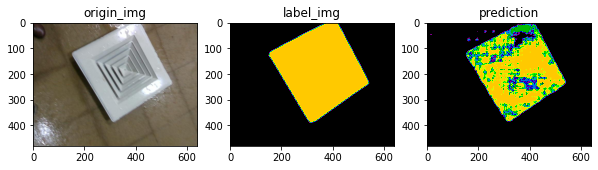

In [43]:
prediction("FCNs_subt_model_batch8_epoch200_RMSprop_lr0.0001.pkl")

## Try to use the model you just trained to predict!

In [30]:
%cd models/subt_model
%ls

/home/sis_2020/ctsphub-workshop-2020/06-semantic-segmentation/models/subt_model
FCNs_subt_model_batch3_epoch0_RMSprop_lr0.0001.pkl
FCNs_subt_model_batch3_epoch10_RMSprop_lr0.0001.pkl
FCNs_subt_model_batch3_epoch11_RMSprop_lr0.0001.pkl
FCNs_subt_model_batch3_epoch12_RMSprop_lr0.0001.pkl
FCNs_subt_model_batch3_epoch13_RMSprop_lr0.0001.pkl
FCNs_subt_model_batch3_epoch14_RMSprop_lr0.0001.pkl
FCNs_subt_model_batch3_epoch15_RMSprop_lr0.0001.pkl
FCNs_subt_model_batch3_epoch16_RMSprop_lr0.0001.pkl
FCNs_subt_model_batch3_epoch17_RMSprop_lr0.0001.pkl
FCNs_subt_model_batch3_epoch18_RMSprop_lr0.0001.pkl
FCNs_subt_model_batch3_epoch19_RMSprop_lr0.0001.pkl
FCNs_subt_model_batch3_epoch1_RMSprop_lr0.0001.pkl
FCNs_subt_model_batch3_epoch20_RMSprop_lr0.0001.pkl
FCNs_subt_model_batch3_epoch21_RMSprop_lr0.0001.pkl
FCNs_subt_model_batch3_epoch22_RMSprop_lr0.0001.pkl
FCNs_subt_model_batch3_epoch23_RMSprop_lr0.0001.pkl
FCNs_subt_model_batch3_epoch24_RMSprop_lr0.0001.pkl
FCNs_subt_model_batch3_epoch2_RMSprop_

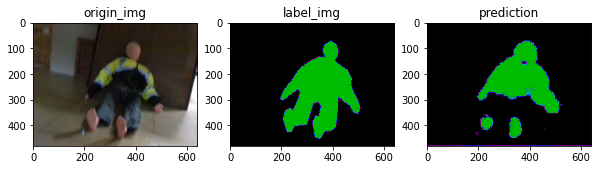

In [45]:
prediction("FCNs_subt_model_batch3_epoch24_RMSprop_lr0.0001.pkl")

backpack = 1, survivor = 2, vent = 3, phone = 4